# Test over Synthetic Data - part 2

Now, we'll try this method on another boolean function that has more predictors (both actual and false).

We will generate 1500 data points. Each data point will contain 100 predictors ($X_i = x_{i1}, x_{i2}, \dots, x_{i100}$) and the response of the system ($y_i$). To generate the random data points $\mathbf{X}=<X_1, X_2, \dots, X_{1500}>$, we sample a thousand times from the binomial distribution with $n=100$ and $p=0.5$.

In [1]:
import importlib
import sys
main_spec = importlib.util.find_spec("main")
found = main_spec is not None
if not found:
    !rm -rf noisy-generalized-boolean
    !git clone https://github.com/RohanBh/noisy-generalized-boolean
    sys.path.append('noisy-generalized-boolean')

In [2]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import main
from IPython.display import FileLink
import os

In [3]:
X = np.random.rand(1500, 100)
X = np.round(X)
X

array([[0., 1., 1., ..., 1., 0., 1.],
       [1., 1., 0., ..., 0., 1., 0.],
       [1., 0., 0., ..., 1., 0., 1.],
       ...,
       [1., 1., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 1., 1., ..., 0., 0., 1.]])

Now that we have $\mathbf{X}$, it's time to generate our synthetic system's response $\mathbf{Y}$. We say that the underlying boolean function depends only on the following 6 predictors out of 100 predictors:
                $$M = <x_{13}, x_{31}, x_{38}, x_{55}, x_{77}, x_{89}>$$

We'll represent this function by $F: \{0,1\}^6 \rightarrow \mathbb{Z}_{4} $, where $\mathbb{Z}_{4} = \{0, 1, 2, 3\}$.

The choice of $F$ is very simple. If the *boolean OR* of the actual predictors is *True*, then the bool_func generates:

$$
\begin{align*}
     y &= 0 \:\text{ w.p. }\: 0.9 \\
       &= 1 \:\text{ w.p. }\: 0.05 \\
       &= 2 \:\text{ w.p. }\: 0 \\
       &= 3 \:\text{ w.p. }\: 0.05
\end{align*}
$$

And if the *boolean OR* evaluates to be *False*, then bool_func generates

$$
\begin{align*}
     y &= 0 \:\text{ w.p. }\: 0 \\
       &= 1 \:\text{ w.p. }\: 0.1 \\
       &= 2 \:\text{ w.p. }\: 0.7 \\
       &= 3 \:\text{ w.p. }\: 0.2
\end{align*}
$$

Here "w.p." abbreviation stands for *with probability*.

In [4]:
def bool_func(xi):
    """Takes an row of truth table and returns the response 
    according to the boolean function"""
    on_true = [0.9, 0.05, 0, 0.05]
    on_false = [0, 0.1, 0.7, 0.2]
    weights =  on_true if np.any(xi) else on_false
    return np.random.choice(4, p=weights)

With the above defined function, we'll generate the response of the system for input $\mathbf{X}$.

In [5]:
X_actual = X[:, [89, 77, 55, 38, 31, 13]]
X_actual.shape

(1500, 6)

Now, we generate the response of the synthetic system $\mathbf{Y}$, for all $1500$ rows in $\mathbf{X}$.

In [6]:
Y = np.apply_along_axis(bool_func, axis=1, arr=X_actual)
Y.shape

(1500,)

Now we have all we need. Let's see if our statistical method can predict which predictors does the response depends upon.

We call the `metropolis` function from the module `main`. This function uses a **Metropolis-Hastings** MCMC algorithm. This algorithm runs a markov chain over the model space $\mathcal{M}$ and generates samples of possible models with the posterior probability $P(M \mid \mathbf{Y}, \mathbf{X})$. This behavior is true only after the markov chain has reached a steady state.

The `metropolis` function returns the generated samples.

In [7]:
samples = main.metropolis(X, Y, q=4, iterations=50000)

********** Running MCMC **********
500: 500 iterations took 44.106138944625854 seconds
1000: 500 iterations took 8.474246740341187 seconds
1500: 500 iterations took 8.407933712005615 seconds
2000: 500 iterations took 8.23869800567627 seconds
2500: 500 iterations took 8.663992166519165 seconds
3000: 500 iterations took 9.168284177780151 seconds
3500: 500 iterations took 8.924393892288208 seconds
4000: 500 iterations took 8.96053147315979 seconds
4500: 500 iterations took 9.488425254821777 seconds
5000: 500 iterations took 9.435612440109253 seconds
5500: 500 iterations took 9.3507661819458 seconds
6000: 500 iterations took 9.406599998474121 seconds
6500: 500 iterations took 9.228131532669067 seconds
7000: 500 iterations took 8.988181829452515 seconds
7500: 500 iterations took 9.231224298477173 seconds
8000: 500 iterations took 9.021209955215454 seconds
8500: 500 iterations took 8.534892320632935 seconds
9000: 500 iterations took 8.522725582122803 seconds
9500: 500 iterations took 8.69033

In [8]:
if not os.path.exists("data"):
    os.makedirs("data")
pd.DataFrame(samples).to_csv("data/mcmc.csv")
FileLink('data/mcmc.csv')

/home/rohan/Projects/PythonProjects/generalized-noisy-boolean/data/mcmc.csv

Click on the link above to download the generated samples.

In [9]:
plt.ioff() # turn off interactive mode for matplotlib

In [10]:
data = np.array(samples)
data.shape

(49581, 100)

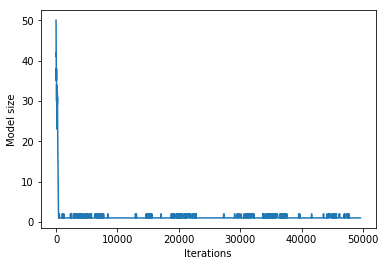

In [11]:
plt.plot(np.arange(data.shape[0]), np.count_nonzero(data, axis=1))
plt.xlabel("Iterations")
plt.ylabel("Model size")
plt.show()

We see that the markov chain enters steady state after around 10000 iterations. We discard the samples before that.

In [12]:
data = data[10000:]
data.shape

(39581, 100)

The next plot gives the posterior probability that predictor $i$ is a part of the model given $Y$ and $X$.

$$
     \begin{align*}
     P(j \in M \mid Y, X) &= \sum_{M \in \mathcal{M}} P(j \in M \mid \mathbf{Y}, \mathbf{X}, M) P(M \mid \mathbf{Y}, \mathbf{X}) \\
         &= \hat{\mathbb{E}}[I_M(j)]_{P(M|\mathbf{Y},\mathbf{X})} \\
         &= \frac{1}{T} \sum_{t=1}^T I_{M^{(t)}} (j)
     \end{align*}
$$

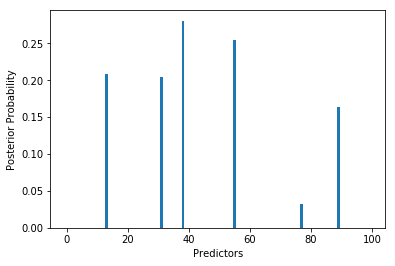

In [13]:
plt.bar(np.arange(data.shape[1]), data.mean(axis=0))
plt.xlabel("Predictors")
plt.ylabel("Posterior Probability")
plt.show()

We can see that the **actual predictors** have very high posterior probability.

In [14]:
predicted_model = data.mean(axis=0) > 0
predicted_model.nonzero()

(array([13, 31, 38, 55, 77, 89]),)

As we can see, the only predictors with non zero posterior are the ones belonging to our original boolean function.

In [15]:
pd.DataFrame(data).assign(count=-1).groupby(list(range(100))).count()

count
0     1     2     3     4     5     6     7     8     9     10    11    12    13    14    15    16    17    18    19    20    21    22    23    24    25    26    27    28    29    30    31    32    33    34    35    36    37    38    39    40    41    42    43    44    45    46    47    48    49    50    51    52    53    54    55    56    57    58    59    60    61    62    63    64    65    66    67    68    69    70    71    72    73    74    75    76    77    78    79    80    81    82    83    84    85    86    87    88    89    90    91    92    93    94    95    96    97    98    99          
False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False True  False False False False False False False False False False   6322
                                                                                                                                                                                                                                                                                                                                                                                                                                                                              True  False False False False False False False False False False False False False False False False False False False False False False    770
                                                                                                                                                                                                                                                                                                                                          True  False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False   5306
                                                                                                                                                                                                                                                                                                                                                                                                                                                                              True  False False False False False False False False False False False False False False False False False False False False False False    265
                                                                                                                                                                                                                                    True  False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False  10533
                                                                                                                                                                                                                                                                                                                                                                